In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 3.2 MB/s eta 0:00:00


In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import RegexpTokenizer





In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

def get_top_n_words(data, n=None):
    vec = CountVectorizer(stop_words='english').fit(data)
    bag = vec.transform(data)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]



def plot_top_words(word_df, x_label='Frequency', y_label='Word', title='Top Words', file_location=None):
    # Rename columns for consistency
    word_df.columns = ['word', 'freq']

    # Generate color palette
    # colors = sns.color_palette("deep", len(word_df))

    # Create the plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=word_df,
        x='freq',
        y='word',
        # hue='word',
        dodge=False
        # palette=colors
    )


    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()

    # Save plot if path is provided
    if file_location:
        plt.savefig(file_location, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {file_location}")

    # Show the plot
    plt.show()


In [5]:
from sklearn import set_config
set_config(display='diagram')


In [6]:
data_news = pd.read_csv('cleaned_news.csv')

In [7]:
data_news.shape, data_news.isna().sum()

((38638, 9),
 title                      0
 text                       0
 subject                    0
 label                      0
 text_length                0
 title_length               0
 exclamations_mark_count    0
 questions_mark_count       0
 uppercase_words_count      0
 dtype: int64)

In [8]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 6.4 MB/s eta 0:00:00


In [9]:
import re
import string
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.base import BaseEstimator, TransformerMixin

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = stopwords.words('english')
        self.freqwords = set(['said', 'trump', 'president', 'people', 'state', 'reuters', 'new', 'donald', 'house', 'government'])
        self.stopwords_set = set(self.stop_words).union(self.freqwords)
        self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

    def preprocess_text(self, text):
        # Lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)

        # Remove standalone numbers
        text = re.sub(r'\b\d+\b', '', text)

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)


        # Remove possessives like "trump's" → "trump"
        text = re.sub(r"'s\b", "", text)

        # Remove punctuation
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)


        # Remove newlines and unicode punctuation
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r'[’“”…]', '', text)

        # Remove emojis
        text = emoji.replace_emoji(text, replace='')

        # Expand contractions
        contractions = {
            "isn't": "is not", "he's": "he is", "wasn't": "was not", "there's": "there is",
            "couldn't": "could not", "won't": "will not", "they're": "they are", "she's": "she is",
            "wouldn't": "would not", "haven't": "have not", "that's": "that is", "you've": "you have",
            "what's": "what is", "weren't": "were not", "we're": "we are", "hasn't": "has not",
            "you'd": "you would", "shouldn't": "should not", "let's": "let us", "they've": "they have",
            "you'll": "you will", "i'm": "i am", "we've": "we have", "it's": "it is", "don't": "do not",
            "that´s": "that is", "i´m": "i am", "it’s": "it is", "she´s": "she is", "i’m": "i am",
            "i’d": "i did", "there’s": "there is"
        }

        for contraction, expanded in contractions.items():
            text = re.sub(rf"\b{re.escape(contraction)}\b", expanded, text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize
        tokens = self.tokenizer.tokenize(text)

        # Lemmatize first
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]

        # Then remove stopwords (after lemmatization to catch more)
        tokens = [word for word in tokens if word not in self.stopwords_set]

        return ' '.join(tokens)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess_text(text) for text in X]


## TextPreprocessor

In [10]:
nltk.download('punkt')  # Do this once
data_news['text_cleaned'] = TextPreprocessor().fit_transform(data_news['text'])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Top Common Words Before cleaning the text

In [ ]:
clean_count = pd.DataFrame(get_top_n_words(data_news['text'], 10))

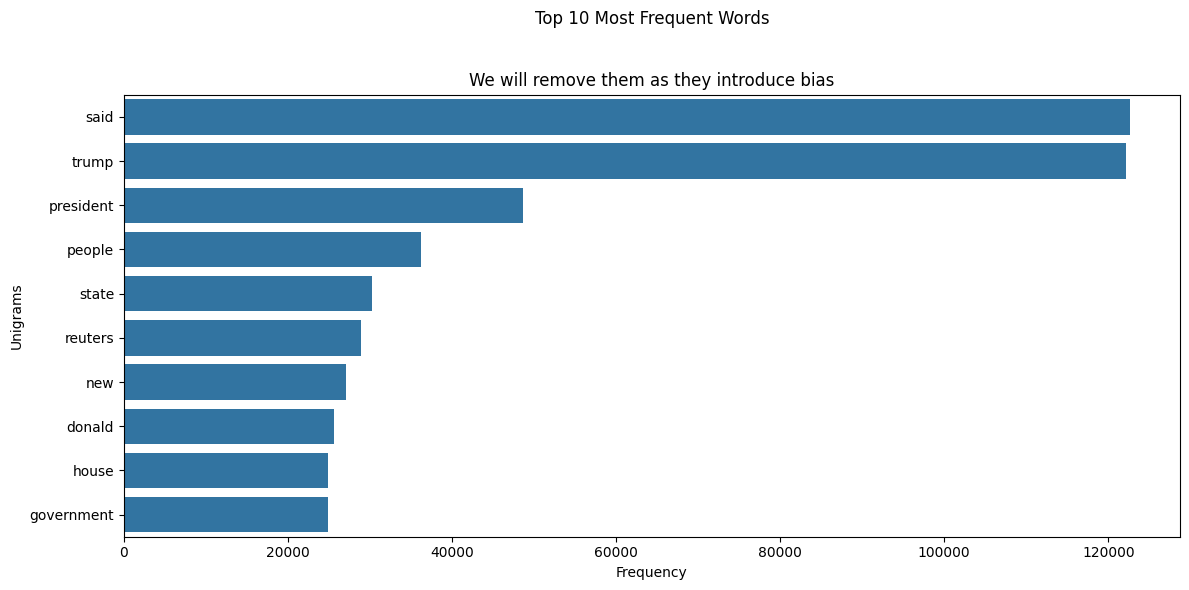

In [ ]:
plot_top_words(
    clean_count,
    title='Top 10 Most Frequent Words\n\n\nWe will remove them as they introduce bias',
    x_label='Frequency',
    y_label='Unigrams',
)

## Top words after preprocessing the text

In [ ]:
preprocess_count = pd.DataFrame(get_top_n_words(data_news['text_cleaned'], 10))


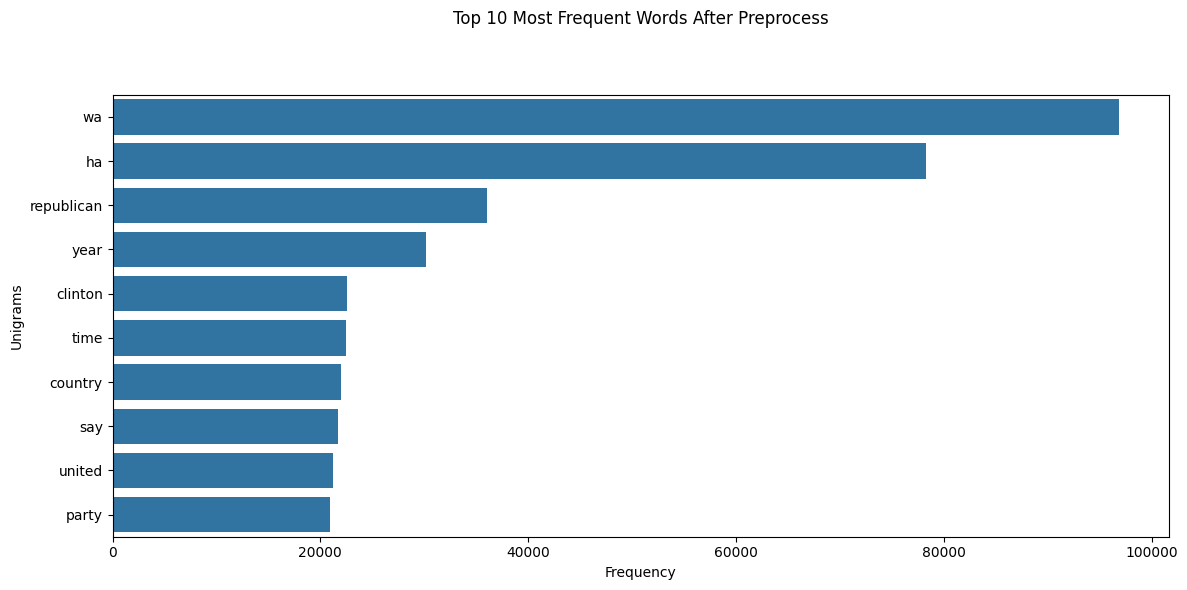

In [ ]:
plot_top_words(
    preprocess_count,
    title='Top 10 Most Frequent Words After Preprocess\n\n\n',
    x_label='Frequency',
    y_label='Unigrams',
)

## Evaluating the performance of the navie model first

In [56]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
def train_and_evaluate_model(X,y,model=MultinomialNB(), model_name='MultinominalNB', vecotrizer='CountVectorizer'):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.20,
                                                    random_state=42)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    f1score = f1_score(predicted, y_test)
    print(f'{model_name} model accuracy is {f1score*100 : 04.2f}% using {vecotrizer}')
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, predicted))
    return model, predicted, f1score, X_test, y_test


In [57]:
# vecotrization

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')


tfid = TfidfVectorizer(
    stop_words=None,
    ngram_range=(1,1),
    tokenizer=token.tokenize,
    token_pattern=None
)

text_counts_1_2 = tfid.fit_transform(data_news['text_cleaned'])


In [58]:
_, _, _ , _, _ = train_and_evaluate_model(text_counts_1_2, data_news['label'])

MultinominalNB model accuracy is  90.59% using CountVectorizer
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      4238
           1       0.97      0.85      0.91      3490

    accuracy                           0.92      7728
   macro avg       0.93      0.91      0.92      7728
weighted avg       0.93      0.92      0.92      7728



## Conclusion
> Built a baseline Multinomial Naive Bayes model using CountVectorizer, achieving 90% F1-score.

> Let's build a more robust model by using metadata egineered features + ensemble learning + hyperparameter tunning

## Creating a pipline for optimizing vetorizer and classifier parameters

In [ ]:
data_news.head()

,Unnamed: 0,title,text,label,text_length,title_length,exclamations_mark_count,questions_mark_count,uppercase_words_count,text_cleaned
0,0,BOOM! WATCH Kids Learn Tough Lesson About Redi...,Kids should be learning the benefits of capita...,1,143,96,0,0,0,kid learning benefit capitalism school reason ...
1,1,GOD SQUAD: Jury Finds Polygamous Mormon Towns ...,Jamie Ross Courthouse News ServicePHOENIX Tw...,1,2736,94,0,0,7,jamie ross courthouse news servicephoenix two ...
2,2,Putin: We'll have to retaliate against 'illega...,"SAVONLINNA, Finland (Reuters) - President Vlad...",0,2654,63,0,2,10,savonlinna finland reuters vladimir putin thur...
3,3,VIDEO: Top 10 Most Embarrassing Presidential F...,21st Century Wire says These family members ma...,0,965,59,0,0,15,21st century wire say family member made life ...
4,4,Camera shows Vietnamese suspect's 'aggressive'...,KUALA LUMPUR (Reuters) - A Vietnamese woman ac...,0,2458,77,0,0,12,kuala lumpur reuters vietnamese woman accused ...


In [12]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 59.1 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [86]:
import pandas as pd
import textstat
import re

# # Define known sensational and source terms
# sensational_starts = ['BREAKING', 'SHOCKING', 'ALERT', 'URGENT', 'JUST IN']
# known_sources = [
#     #  International & US-based sources
#     'Reuters', 'Associated Press', 'AP', 'BBC', 'CNN', 'Fox News', 'NBC News', 'CBS News',
#     'The Guardian', 'New York Times', 'NYT', 'Washington Post', 'Bloomberg', 'The Wall Street Journal',
#     'WSJ', 'NPR', 'Al Jazeera', 'Time', 'USA Today', 'Politico', 'ABC News', 'The Hill',
#     'Newsweek', 'Forbes', 'Business Insider', 'Vice News', 'MSNBC',

#     # 🇳🇵 Nepali sources
#     'The Kathmandu Post', 'Kantipur', 'MyRepublica', 'Setopati', 'OnlineKhabar',
#     'Himalayan Times', 'Nagarik News', 'Ratopati', 'Annapurna Post', 'Nepali Times',
#     'BBC Nepali', 'Gorkhapatra', 'ImageKhabar', 'DeshSanchar', 'Baahrakhari',
#     'Khabarhub', 'Himal Khabar', 'Mountain TV', 'NepalNews', 'News24 Nepal'
# ]


# Helper to clean and lowercase
def safe_text(text):
    return text if isinstance(text, str) else ""

# Text Length
data_news['text_length'] = data_news['text'].apply(lambda x: len(safe_text(x)))

# Uppercase Words Count
data_news['uppercase_words_count'] = data_news['text'].apply(
    lambda x: sum(word.isupper() for word in safe_text(x).split())
)

# Has Uppercase Emphasis (binary)
data_news['has_uppercase_emphasis'] = (data_news['uppercase_words_count'] > 0).astype(int)

# Long Text Flag
data_news['long_text_flag'] = (data_news['text_length'] > 3000).astype(int)

# Readability Score
data_news['readability_score'] = data_news['text'].apply(
    lambda x: textstat.flesch_reading_ease(x) if isinstance(x, str) and len(x.strip()) > 0 else 0
)

# Text Length Bin (Quantile)
data_news['text_length_bin'] = pd.qcut(data_news['text_length'], q=4, labels=[0, 1, 2, 3])

# Punctuation Alert (! or ?)
data_news['punctuation_alert'] = data_news['text'].apply(
    lambda x: int(bool(re.search(r'[!?]', safe_text(x))))
)

# # Starts Sensational (headline-style triggers)
# data_news['starts_sensational'] = data_news['text'].apply(
#     lambda x: int(any(safe_text(x).strip().upper().startswith(trigger) for trigger in sensational_starts))
# )

# First Sentence Length (number of words)
data_news['first_sentence_length'] = data_news['text'].apply(
    lambda x: len(re.split(r'[.!?]', safe_text(x).strip())[0].split())
)

# # Has Known Source Mention
# data_news['has_known_source_mention'] = data_news['text'].apply(
#     lambda x: int(any(source.lower() in safe_text(x).lower() for source in known_sources))
# )

# Drop intermediate/raw columns
data_news.drop(columns=['text_length'], inplace=True, axis=1)


In [75]:
data_news.readability_score

,readability_score
0,51.453132
1,35.269771
2,45.996662
3,78.787724
4,54.488584
...,...
38633,48.846546
38634,39.762190
38635,64.096921
38636,53.375000


In [76]:
# data_news.drop(columns=['exclamations_mark_count', 'questions_mark_count',
#         'punctuation_alert_score',
#        'has_alert_punctuation', 'punctuation_density'], axis=1, inplace=True)

In [94]:
# final_df = news_df.merge(new_text_df, left_index=True, right_index=True)

final_df = data_news.drop(columns=['title', 'text', 'title_length', 'exclamations_mark_count', 'questions_mark_count'])

# final_df.rename(columns={'no_sw_lem': 'text_cleaned'}, inplace=True)
# final_df.head()

final_df.rename(columns={'text_cleaned': 'text'}, inplace=True)

X = final_df.drop(columns=['label' ,'subject'])
y = final_df.label



X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.20,
                                                    random_state=42
                                                    )

In [95]:


X.columns

Index(['uppercase_words_count', 'text', 'has_uppercase_emphasis',
       'long_text_flag', 'readability_score', 'text_length_bin',
       'punctuation_alert', 'first_sentence_length'],
      dtype='object')

In [96]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30910, 8), (7728, 8), (30910,), (7728,))

In [97]:
X_train.columns

Index(['uppercase_words_count', 'text', 'has_uppercase_emphasis',
       'long_text_flag', 'readability_score', 'text_length_bin',
       'punctuation_alert', 'first_sentence_length'],
      dtype='object')

In [98]:
X_train.dropna(inplace=True, how='any')
X_test.dropna(inplace=True, how='any')
y_train.dropna(inplace=True, how='any')
y_test.dropna(inplace=True, how='any')

## PipeLine to merge text_data and metadata features together

In [99]:

trf1 = ColumnTransformer(
    transformers=[
        ('vectorizer', CountVectorizer(), 'text')
    ],
    remainder='passthrough',  # keeps metadata columns

    force_int_remainder_cols=False # treat remainder columns by name, not index.
)

model_pipe = Pipeline(
    steps=[
        ('trf1', trf1),
        ('classifier', XGBClassifier(objective='binary:logistic', eval_metric='logloss'))
    ]
)



model_pipe  # Displays a diagram of the pipeline

Pipeline(steps=[('trf1',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('vectorizer',
                                                  CountVectorizer(),
                                                  'text')])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [100]:
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('vectorizer',
                                                  CountVectorizer(),
                                                  'text')])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [101]:
from sklearn.metrics import f1_score, classification_report
y_pred = model_pipe.predict(X_test)

f1score= f1_score(y_test, y_pred)*100

print(f"Accracy of the model is {f1score:.4f}%")
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accracy of the model is 98.2138%
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4238
           1       0.99      0.98      0.98      3490

    accuracy                           0.98      7728
   macro avg       0.98      0.98      0.98      7728
weighted avg       0.98      0.98      0.98      7728



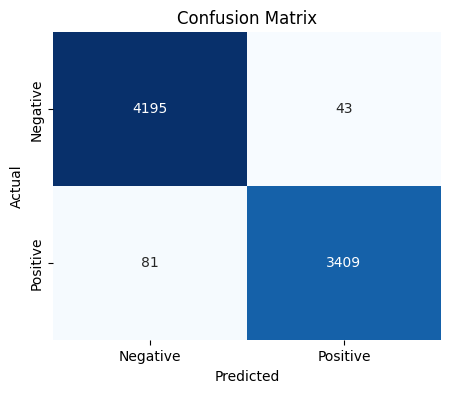

In [102]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [103]:
from sklearn.metrics import precision_score, recall_score

print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")


Precision: 0.9875434530706837
Recall: 0.9767908309455587


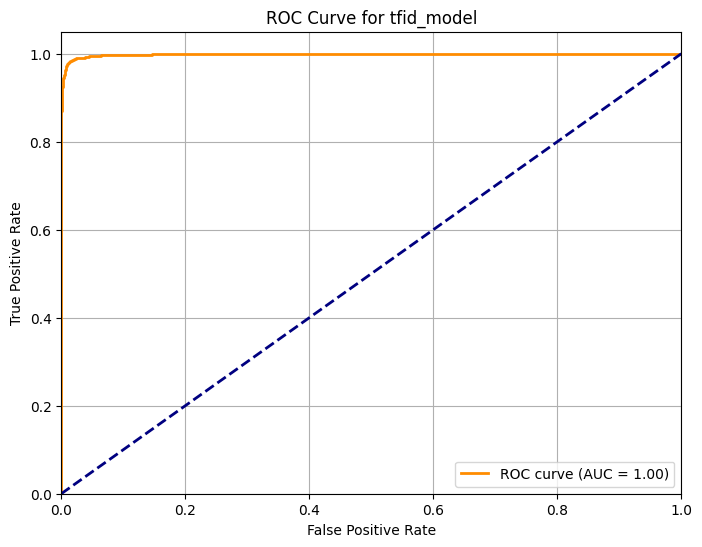

In [104]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Get predicted probabilities for the positive class
y_probs = model_pipe.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for tfid_model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Using only text feature

In [ ]:
text_model = model_pipe.fit(X_train[['text']], y_train)

In [ ]:
from sklearn.metrics import f1_score, classification_report
text_y_pred = text_model.predict(X_test[['text']])

f1score= f1_score(y_test, text_y_pred)*100

print(f"Accracy of the model is {f1score:.4f}%")
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, text_y_pred))

Accracy of the model is 97.5808%
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4238
           1       0.99      0.97      0.98      3490

    accuracy                           0.98      7728
   macro avg       0.98      0.98      0.98      7728
weighted avg       0.98      0.98      0.98      7728



In [ ]:
import numpy as np

text_model.set_params(**{'classifier__colsample_bytree': np.float64(0.8148780624261369),
 'classifier__learning_rate': np.float64(0.20434241907782077),
 'classifier__max_depth': 5,
 'classifier__n_estimators': 456,
 'classifier__scale_pos_weight': 5,
 'classifier__subsample': np.float64(0.8683831592708489),
 'trf1__vectorizer__max_features': 9910,
 'trf1__vectorizer__ngram_range': (1, 2)}

)
text_model.fit(X_train[['text']], y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('vectorizer',
                                                  CountVectorizer(max_features=9910,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text')])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=np.float64(0.81487806242613...
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.20434241907782077),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=456, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
from sklearn.metrics import f1_score, classification_report
text_y_pred = text_model.predict(X_test[['text']])

f1score= f1_score(y_test, text_y_pred)*100

print(f"Accracy of the model is {f1score:.4f}%")
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, text_y_pred))

Accracy of the model is 98.1943%
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4238
           1       0.98      0.98      0.98      3490

    accuracy                           0.98      7728
   macro avg       0.98      0.98      0.98      7728
weighted avg       0.98      0.98      0.98      7728



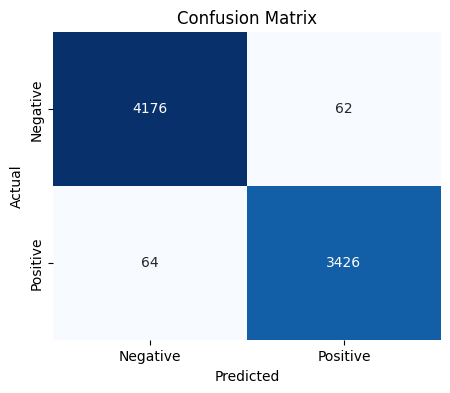

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, text_y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

## Let's use TFid vectorizer

In [ ]:
X.columns

Index(['text_length', 'exclamations_mark_count', 'questions_mark_count',
       'uppercase_words_count', 'text'],
      dtype='object')

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Define column names
text_column = 'text'
numeric_columns = ['text_length', 'exclamations_mark_count', 'questions_mark_count', 'uppercase_words_count']

# Define the ColumnTransformer
trf_tfid = ColumnTransformer(
    transformers=[
        ('vectorizer', TfidfVectorizer(ngram_range=(1,2)), text_column)
        # ('scaler', StandardScaler(), numeric_columns)  # This scales your numeric features
    ],
    remainder='drop',  # Drop any other features not explicitly transformed
    verbose_feature_names_out=False
)

# Define the full pipeline
tfid_model = Pipeline(
    steps=[
        ('trf1', trf_tfid),
        ('classifier', XGBClassifier(objective='binary:logistic', eval_metric='logloss'))
    ]
)


In [ ]:
tfid_model.fit(X_train[['text']], y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(transformers=[('vectorizer',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'text')],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
from sklearn.metrics import f1_score, classification_report
y_pred_tfid = tfid_model.predict(X_test)

f1score= f1_score(y_test, y_pred_tfid)*100

print(f"Accracy of the model is {f1score:.4f}%")
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred_tfid, target_names=['Real News', 'Fake News'], digits=4))


Accracy of the model is 97.5780%
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

   Real News     0.9709    0.9903    0.9805      4238
   Fake News     0.9880    0.9639    0.9758      3490

    accuracy                         0.9784      7728
   macro avg     0.9794    0.9771    0.9781      7728
weighted avg     0.9786    0.9784    0.9784      7728



 Just after using the countvectorizer with meta data  features our model has accuracy up 98.55%. Let's use hpyerparameter for building a more robust model

## Tuning our model For Countvectorizer

In [115]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


param_dist = {
    'trf1__vectorizer__ngram_range': [(1, 1), (1, 2)],
    'trf1__vectorizer__max_features': randint(3000, 10000),

    # XGBoost params
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__n_estimators': randint(200, 500),
    'classifier__max_depth': randint(3, 10),
    'classifier__subsample': uniform(0.7, 0.3),
    'classifier__colsample_bytree': uniform(0.7, 0.3),
    'classifier__scale_pos_weight': [1.0, 1.2, 1.5, 2, 5, 7],
    'classifier__min_child_weight': randint(1, 10),
    'classifier__gamma': uniform(0, 5),
    'classifier__reg_alpha': uniform(0, 1),
    'classifier__reg_lambda': uniform(1, 10),
}



from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_cv = RandomizedSearchCV(
    model_pipe,
    param_distributions=param_dist,
    n_iter=30,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)


In [116]:
random_search_cv.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('trf1',
                                              ColumnTransformer(force_int_remainder_cols=False,
                                                                remainder='passthrough',
                                                                transformers=[('vectorizer',
                                                                               CountVectorizer(max_features=9910,
                                                                                               ngram_range=(1,
                                                                                                            2)),
                                                                               'text')])),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,...
                                        'classifier__scale_pos_weight': [1.0,
                                                                         1.2,
                                                                         1.5, 2,
                                                                         5, 7],
                                        'classifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f06393f07d0>,
                                        'trf1__vectorizer__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0639cf3790>,
                                        'trf1__vectorizer__ngram_range': [(1,
                                                                           1),
                                                                          (1,
                                                                           2)]},
                   random_state=42, scoring='f1', verbose=2)

In [117]:
best_params = random_search_cv.best_params_
from pprint import pprint
pprint(best_params)

# saving these parameters
import pickle
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

# {'classifier__learning_rate': np.float64(0.24555278841790407),
#  'classifier__max_depth': 5,
#  'classifier__n_estimators': 463,
#  'trf1__vectorizer__max_features': 5638,
#  'trf1__vectorizer__ngram_range': (1, 2)}

# updated params
# {'classifier__colsample_bytree': np.float64(0.8148780624261369),
#  'classifier__learning_rate': np.float64(0.20434241907782077),
#  'classifier__max_depth': 5,
#  'classifier__n_estimators': 456,
#  'classifier__scale_pos_weight': 5,
#  'classifier__subsample': np.float64(0.8683831592708489),
#  'trf1__vectorizer__max_features': 9910,
#  'trf1__vectorizer__ngram_range': (1, 2)}

{'classifier__colsample_bytree': np.float64(0.7583140101984619),
 'classifier__gamma': np.float64(2.056769525283393),
 'classifier__learning_rate': np.float64(0.1499024421534388),
 'classifier__max_depth': 6,
 'classifier__min_child_weight': 2,
 'classifier__n_estimators': 323,
 'classifier__reg_alpha': np.float64(0.7145951041799521),
 'classifier__reg_lambda': np.float64(1.410675167678758),
 'classifier__scale_pos_weight': 1.5,
 'classifier__subsample': np.float64(0.8316914262116908),
 'trf1__vectorizer__max_features': 9070,
 'trf1__vectorizer__ngram_range': (1, 2)}


In [118]:
best_model_pipeline = random_search_cv.best_estimator_

In [119]:
print(f'Cross-Val Score {random_search_cv.best_score_ *100 :.2f}%')



Cross-Val Score 98.42%


In [105]:
import numpy as np

best_model_pipeline = model_pipe.set_params(**
                                            {'classifier__colsample_bytree': np.float64(0.8148780624261369),
 'classifier__learning_rate': np.float64(0.20434241907782077),
 'classifier__max_depth': 5,
 'classifier__n_estimators': 456,
 'classifier__scale_pos_weight': 5,
 'classifier__subsample': np.float64(0.8683831592708489),
 'trf1__vectorizer__max_features': 9910,
 'trf1__vectorizer__ngram_range': (1, 2)}
                                            )

In [120]:
best_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('vectorizer',
                                                  CountVectorizer(max_features=9070,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text')])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=np.float64(0.75831401019846...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.1499024421534388),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=323,
                               n_jobs=None, num_parallel_tree=None, ...))])

## Evaluating our model

In [121]:
from sklearn.metrics import f1_score, classification_report
y_pred = best_model_pipeline.predict(X_test)

f1score= f1_score(y_test, y_pred)*100

In [122]:
print(f"Accracy of the model is {f1score:.4f}%")
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Real News', 'Fake News'], digits=4))

Accracy of the model is 98.4204%
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

   Real News     0.9852    0.9889    0.9870      4238
   Fake News     0.9865    0.9819    0.9842      3490

    accuracy                         0.9858      7728
   macro avg     0.9858    0.9854    0.9856      7728
weighted avg     0.9858    0.9858    0.9858      7728



In [123]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)



In [124]:
cm


array([[4191,   47],
       [  63, 3427]])

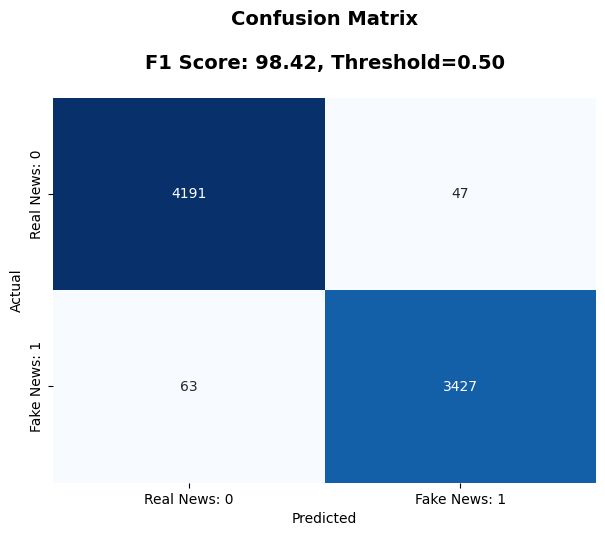

In [125]:
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Real News: 0', 'Fake News: 1'],
            yticklabels=['Real News: 0', 'Fake News: 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\n\nF1 Score: {f1score:.2f}, Threshold=0.50\n', fontsize=14, fontweight='bold', pad=5)


plt.savefig('confusion_matrix.png')
plt.show()

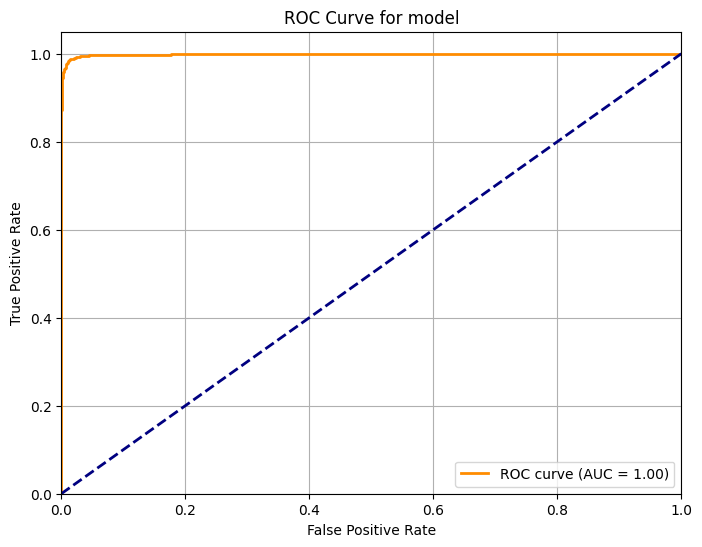

In [126]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Get predicted probabilities for the positive class
y_probs = best_model_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

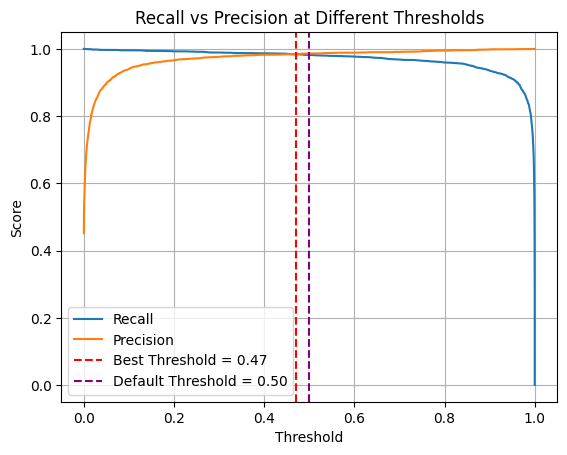

In [127]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Compute index where precision and recall are closest
diff = np.abs(precision[:-1] - recall[:-1])  # Exclude last precision/recall element
min_index = np.argmin(diff)
best_threshold = thresholds[min_index]

# Plot precision and recall
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, precision[:-1], label='Precision')

# Add vertical line at the best threshold
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.axvline(x=0.5, color='purple', linestyle='--', label=f'Default Threshold = {0.5:.2f}')


# Labels and formatting
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall vs Precision at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()


              precision    recall  f1-score   support

           0     0.9891    0.9858    0.9875      4238
           1     0.9829    0.9868    0.9848      3490

    accuracy                         0.9863      7728
   macro avg     0.9860    0.9863    0.9862      7728
weighted avg     0.9863    0.9863    0.9863      7728
 


F1 Score: 98.484415


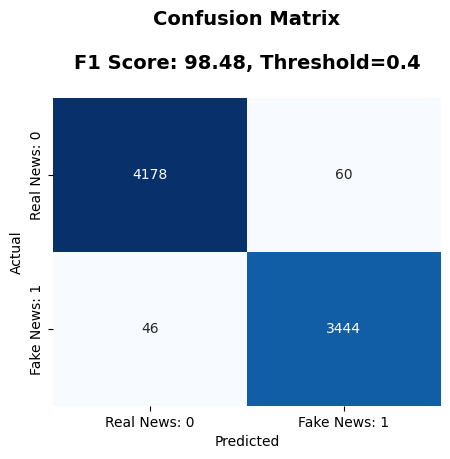

In [152]:
y_probs = best_model_pipeline.predict_proba(X_test)[:, 1]

# Try a lower threshold to increase recall
threshold =0.40
y_pred = (y_probs >= threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix


final_f1score = f1_score(y_test, y_pred)*100
print(classification_report(y_test, y_pred, digits=4), '\n\n')
print(f"F1 Score: {final_f1score:2f}")


plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Real News: 0', 'Fake News: 1'],
            yticklabels=['Real News: 0', 'Fake News: 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\n\nF1 Score: {final_f1score :.2f}, Threshold={threshold}\n', fontsize=14, fontweight='bold', pad=5)

plt.savefig('confusion_matrix.png')
plt.show()


> We will use threshold_value= 0.53 for our model prediction.




## Conclusion
After combining meta data features created using feature engineering, and fine tunning our xbgoost model using randomsearch cv 98.5% accuracy is achieved.

In [132]:
# saving model

import joblib

joblib.dump(best_model_pipeline, 'model_pipeline.pkl')

['model_pipeline.pkl']

In [133]:
model_pipe = joblib.load('model_pipeline.pkl')

In [134]:
model_pipe

Pipeline(steps=[('trf1',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('vectorizer',
                                                  CountVectorizer(max_features=9070,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text')])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=np.float64(0.75831401019846...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.1499024421534388),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=323,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [141]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.0 MB/s eta 0:00:00


In [142]:
# Use the first step of the pipeline to transform X_test and X_train
X_train_transformed = best_model_pipeline.named_steps['trf1'].transform(X_train)
X_test_transformed = best_model_pipeline.named_steps['trf1'].transform(X_test)


In [145]:
# Get CountVectorizer feature names
vectorizer = model_pipe.named_steps['trf1'].named_transformers_['vectorizer']
vectorizer_features = vectorizer.get_feature_names_out()

# Get metadata (remainder) feature names
metadata_features = model_pipe.named_steps['trf1'].transformers_[1][2]  # remainder='passthrough'

# Final combined feature names
feature_names = list(vectorizer_features) + list(metadata_features)



In [146]:
import shap

xgb_model = model_pipe.named_steps['classifier']
explainer = shap.Explainer(xgb_model,masker=X_train_transformed.toarray(), feature_names=feature_names, model_output='probability')

In [147]:
import numpy as np
# Double-check your labels
print("Unique values in y_train:", np.unique(y_train))
print("Value counts:", np.bincount(y_train))

Unique values in y_train: [0 1]
Value counts: [16953 13957]


In [148]:
shap_values = explainer(X_test_transformed.toarray())


100%|===================| 7698/7728 [00:43<00:00]       

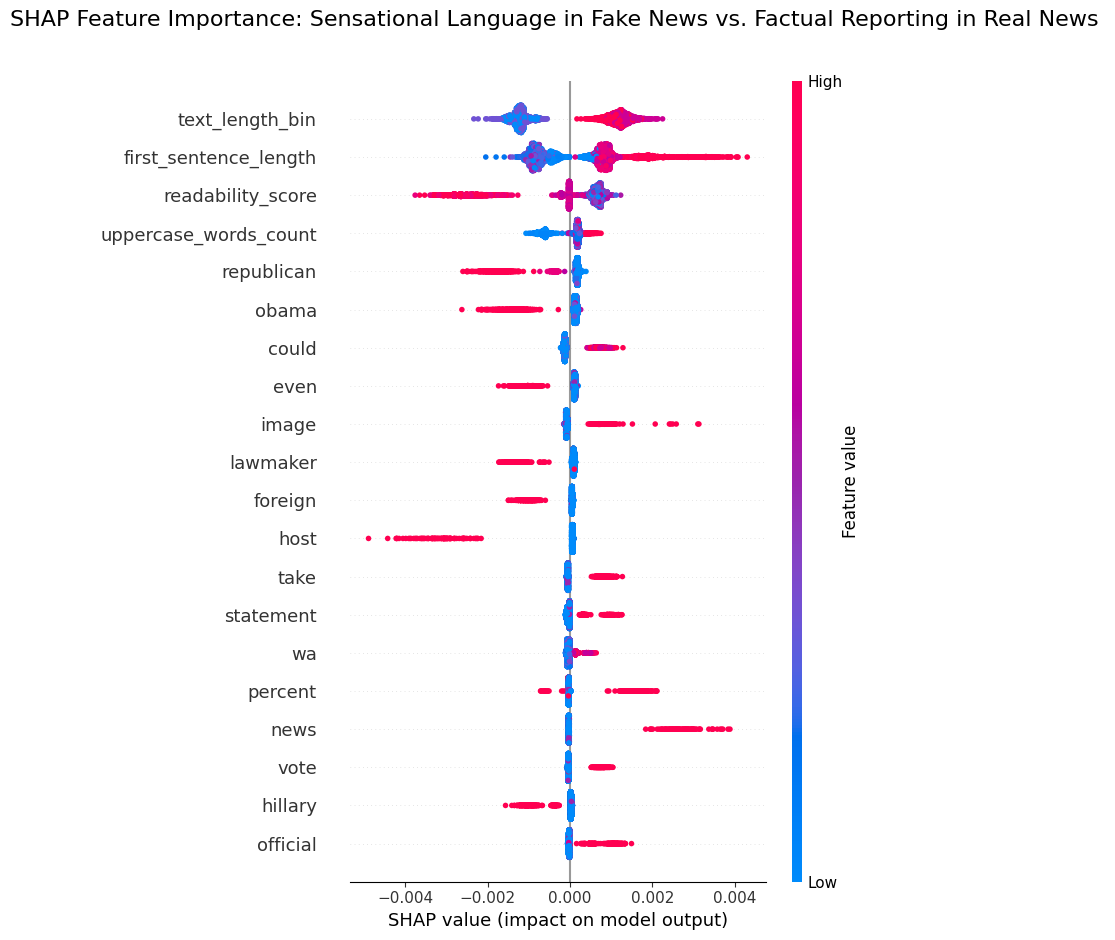

<Figure size 640x480 with 0 Axes>

In [149]:
import matplotlib.pyplot as plt
# Generate the SHAP summary plot
# Add a custom title

plt.title("SHAP Feature Importance: Sensational Language in Fake News vs. Factual Reporting in Real News \n \n", fontsize=16)
shap.summary_plot(shap_values.values, X_test_transformed.toarray(), feature_names=feature_names)


plt.tight_layout()  # Optional: to prevent overlap
plt.show()

## SHAP Feature Importance Summary

SHAP values reveal key features driving the model’s classification of news as fake (1) or real (0):

* **Fake news** is associated with longer text, frequent uppercase words, exclamation marks, and question marks, reflecting sensational and emotional language.
* **Real news** features frequent use of the word “Obama” and terms like  “Hillary,” and “American,” indicating factual reporting and institutional focus.

This analysis confirms the model’s effective use of linguistic and structural cues to differentiate fake from real news.

---



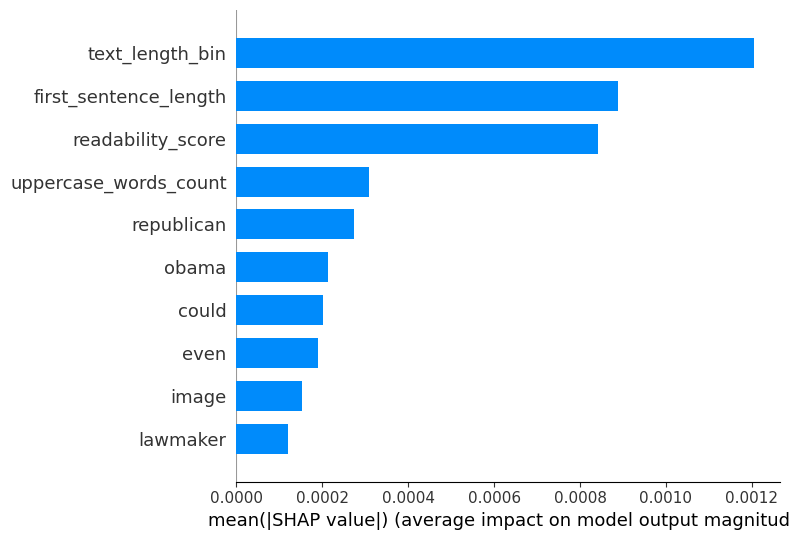

In [150]:

plt.figure(figsize=(2, 2))
shap.summary_plot(shap_values, X_test_transformed.toarray(), feature_names=feature_names, plot_type="bar", max_display=10)
plt.show()